In [11]:
!pip install openpyxl

In [41]:
import pandas as pd
import re
import numpy as np
import datetime
from scipy.optimize import linear_sum_assignment

In [42]:
df2007 = pd.read_excel("ILIDataV2.xlsx", sheet_name="2007")
df2015 = pd.read_excel("ILIDataV2.xlsx", sheet_name="2015")
df2022 = pd.read_excel("ILIDataV2.xlsx", sheet_name="2022")

features = ["joint_number", "distance", "clock", "feature_type", "depth", "length", "width"]

df2007 = df2007.rename(columns={
    "J. no.": "joint_number",
    "log dist. [ft]": "distance",
    "o'clock": "clock",
    "event": "feature_type",
    "depth [%]": "depth",
    "length [in]": "length",
    "width [in]": "width",
})

df2007 = df2007[features]

df2015 = df2015.rename(columns={
    "J. no.": "joint_number",
    "Log Dist. [ft]": "distance",
    "O'clock": "clock",
    "Event Description": "feature_type",
    "Depth [%]": "depth",
    "Length [in]": "length",
    "Width [in]": "width",
})

df2015 = df2015[features]

df2022 = df2022.rename(columns={
    "Joint Number": "joint_number",
    "ILI Wheel Count \n[ft.]": "distance",
    "O'clock\n[hh:mm]": "clock",
    "Event Description": "feature_type",
    "Metal Loss Depth \n[%]": "depth",
    "Length [in]": "length",
    "Width [in]": "width"
})

df2022 = df2022[features]

# Preprocessing: convert `clock` values to numeric degrees and coerce numeric columns

def clock_to_hours(val):
    if pd.isna(val):
        return np.nan
    
    # Nếu là đối tượng datetime.time
    if isinstance(val, datetime.time):
        return (val.hour % 12) + (val.minute / 60.0) + (val.second / 3600.0)
    
    s = str(val).strip()
    if s == '' or s.lower() == 'nan':
        return np.nan
        
    # Xử lý định dạng hh:mm
    if ':' in s:
        try:
            parts = s.split(':')
            h = int(parts[0]) % 12
            m = int(parts[1])
            return h + (m / 60.0)
        except:
            pass
            
    # Fallback: Nếu là số (giả sử là giờ), hoặc lọc số
    try:
        f_val = float(s)
        # QUAN TRỌNG: Nếu số > 12, có thể nó đang là ĐỘ. Cần quy đổi về GIỜ.
        if f_val > 12: 
            return (f_val % 360) / 30.0
        return f_val % 12
    except:
        s2 = re.sub(r'[^0-9.-]', '', s)
        try:
            f_val = float(s2)
            return (f_val % 360) / 30.0 if f_val > 12 else f_val % 12
        except:
            return np.nan

numeric_cols = ["distance", "depth", "length", "width"]
for name, df in [("df2007", df2007), ("df2015", df2015), ("df2022", df2022)]:
    if 'clock' in df.columns:
        df['clock'] = df['clock'].apply(clock_to_hours).astype('float')
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^0-9.-]', '', regex=True), errors='coerce')


def standardize_events(event_name):
    """
    Hàm chuẩn hóa tên sự kiện dựa trên các từ khóa (Keywords) 
    từ file Business Case và thực tế dữ liệu 3 năm.
    """
    if pd.isna(event_name):
        return "UNKNOWN"
    
    # Chuyển về chữ thường, bỏ khoảng trắng thừa
    name = str(event_name).lower().strip()
    
    # 1. Nhóm METAL LOSS (Đối tượng chính để tính toán)
    if 'metal loss' in name or 'cluster' in name:
        if 'manufacturing' in name:
            return 'METAL_LOSS_MANUFACTURING'
        return 'METAL_LOSS'
    
    # 2. Nhóm FIXED POINTS (Dùng để nắn khoảng cách - Alignment)
    if 'girth' in name and 'weld' in name:
        if 'anomaly' in name:
            return 'WELD_ANOMALY'
        return 'GIRTH_WELD'
    
    if 'valve' in name:
        return 'VALVE'
    
    if 'tap' in name or 'tee' in name:
        return 'FITTING_TEE_TAP'
    
    if 'bend' in name:
        return 'BEND'
    
    if 'flange' in name:
        return 'FLANGE'
    
    if 'agm' in name or 'above ground marker' in name or 'marker' in name:
        return 'AGM'
    
    # 3. Nhóm CASING & REPAIR (Bối cảnh bảo vệ/sửa chữa)
    if 'casing' in name:
        return 'CASING'
    
    if 'sleeve' in name or 'wrap' in name or 'repair' in name or 'recoat' in name:
        return 'REPAIR_PROTECTION'
    
    # 4. Nhóm ANOMALY KHÁC
    if 'dent' in name:
        return 'DENT'
    
    if 'seam weld' in name:
        return 'SEAM_WELD_ANOMALY'
    
    # 5. Các trạm phóng/nhận (Launcher/Receiver)
    if 'launcher' in name or 'receiver' in name or 'trap' in name:
        return 'STATION_COMPONENT'

    return 'OTHER_FEATURE'

# GIẢ SỬ BẠN ĐÃ CÓ 3 DATAFRAME: df_2007, df_2015, df_2022

# Bước 1: Xác định cột chứa tên Event của từng năm (vì tên cột có thể khác nhau)
# 2022: 'Event Description'
# 2015: 'Event Description'
# 2007: 'event'

# Bước 2: Áp dụng chuẩn hóa
df2022['feature_type'] = df2022['feature_type'].apply(standardize_events)
df2015['feature_type'] = df2015['feature_type'].apply(standardize_events)
df2007['feature_type'] = df2007['feature_type'].apply(standardize_events)

# Bước 3: Kiểm tra thử kết quả
print("Thống kê 2022:\n", df2022['feature_type'].value_counts())
print("\nThống kê 2015:\n", df2015['feature_type'].value_counts())
print("\nThống kê 2007:\n", df2007['feature_type'].value_counts())

df2007.to_csv("standardized1/df2007.csv", index=False)
df2015.to_csv("standardized1/df2015.csv", index=False)
df2022.to_csv("standardized1/df2022.csv", index=False)

files = ['standardized1/df2007.csv', 'standardized1/df2015.csv', 'standardized1/df2022.csv']  # replace with your paths
sheets = ['2007', '2015', '2022']
output = 'combined.xlsx'

with pd.ExcelWriter(output, engine='openpyxl') as writer:
    for f, s in zip(files, sheets):
        df = pd.read_csv(f)          # or pd.read_excel / pd.read_json as needed
        df.to_excel(writer, sheet_name=s, index=False)

Thống kê 2022:
 feature_type
METAL_LOSS                  2624
GIRTH_WELD                  1619
BEND                         350
SEAM_WELD_ANOMALY            330
AGM                          136
REPAIR_PROTECTION            112
FITTING_TEE_TAP               21
OTHER_FEATURE                 14
METAL_LOSS_MANUFACTURING      12
DENT                           8
VALVE                          4
CASING                         2
FLANGE                         1
Name: count, dtype: int64

Thống kê 2015:
 feature_type
METAL_LOSS                  1747
GIRTH_WELD                  1607
OTHER_FEATURE                101
BEND                          76
REPAIR_PROTECTION             60
AGM                           24
FITTING_TEE_TAP               24
METAL_LOSS_MANUFACTURING      21
DENT                           6
STATION_COMPONENT              4
VALVE                          4
CASING                         2
WELD_ANOMALY                   1
FLANGE                         1
Name: count, dtype: int6

In [43]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Load the standardized CSVs
df_07 = pd.read_csv('standardized1/df2007.csv')
df_15 = pd.read_csv('standardized1/df2015.csv')
df_22 = pd.read_csv('standardized1/df2022.csv')

def align_reference_and_distance_correction(df_source, df_ref):
    """
    Nắn khoảng cách dựa trên việc khớp chính xác số hiệu Joint.
    """
    # 1. Lọc danh sách các mối hàn (Girth Welds) - vì mỗi mối hàn gắn với một Joint
    anchors_src = df_source[df_source['feature_type'] == 'GIRTH_WELD'].copy()
    anchors_ref = df_ref[df_ref['feature_type'] == 'GIRTH_WELD'].copy()
    
    # 2. Khớp các mối hàn có cùng Joint Number (hoặc ID tương đương)
    # Giả sử cột joint của bạn đã được chuẩn hóa
    common_joints = set(anchors_src['joint_number']).intersection(set(anchors_ref['joint_number']))
    common_joints = sorted(list(common_joints))
    
    # Lấy tọa độ của những Joint xuất hiện ở cả 2 năm
    src_points = anchors_src[anchors_src['joint_number'].isin(common_joints)].sort_values('joint_number')
    ref_points = anchors_ref[anchors_ref['joint_number'].isin(common_joints)].sort_values('joint_number')
    
    # 3. Bổ sung các điểm Fixed Points cực kỳ quan trọng (Valve, Flange) 
    # để làm mốc cứng nếu Joint Number bị nhảy
    fixed_src = df_source[df_source['feature_type'].isin(['VALVE', 'FLANGE'])]
    fixed_ref = df_ref[df_ref['feature_type'].isin(['VALVE', 'FLANGE'])]
    
    old_x = src_points['distance'].tolist() + fixed_src['distance'].tolist()
    new_x = ref_points['distance'].tolist() + fixed_ref['distance'].tolist()
    
    # Sắp xếp lại các điểm neo theo chiều tăng dần của khoảng cách
    combined = sorted(zip(old_x, new_x))
    old_x, new_x = zip(*combined)
    
    # 4. Tạo hàm nắn nội suy
    transform = interp1d(old_x, new_x, kind='linear', fill_value="extrapolate")
    
    # 5. Áp dụng
    df_source['aligned_dist'] = transform(df_source['distance'])
    
    return df_source

df_15_aligned = align_reference_and_distance_correction(df_15, df_22)
df_07_aligned = align_reference_and_distance_correction(df_07, df_22)
df_15_aligned.to_csv("df_15_aligned.csv", index=False)
df_07_aligned.to_csv("df_07_aligned.csv", index=False)

In [44]:
def match_anomalies_refined(df_rec, df_hist, dist_tol=1.5, clock_tol=1.0):
    """
    Nhiệm vụ 4: Khớp các lỗi thực sự sau khi đã loại bỏ cấu kiện đường ống.
    """
    # 1. Định nghĩa danh sách các cấu kiện cần loại bỏ (Pipeline Components)
    components_to_exclude = [
        'GIRTH_WELD', 'VALVE', 'FLANGE', 'AGM', 'CASING', 'FITTING_TEE_TAP', 'STATION_COMPONENT', 'BEND', 'OTHER_FEATURE']
    
    # 2. Lọc Anomalies và LOẠI BỎ CÁC DÒNG CÓ GIÁ TRỊ TRỐNG (NaN)
    rec_anom = df_rec[~df_rec['feature_type'].isin(components_to_exclude)].dropna(subset=['distance', 'clock']).copy()
    hist_anom = df_hist[~df_hist['feature_type'].isin(components_to_exclude)].dropna(subset=['aligned_dist', 'clock']).copy()
    # 
    
    match_results = []
    matched_hist_indices = set()
    matched_rec_indices = set()

    # 3. Gom nhóm theo loại lỗi để đảm bảo "Feature type compatibility"
    # Ví dụ: DENT chỉ khớp với DENT, METAL_LOSS chỉ khớp với METAL_LOSS
    unique_types = set(rec_anom['feature_type']).intersection(set(hist_anom['feature_type']))

    for f_type in unique_types:
        type_rec = rec_anom[rec_anom['feature_type'] == f_type]
        type_hist = hist_anom[hist_anom['feature_type'] == f_type]
        
        # Khớp theo từng Joint để tăng độ chính xác tuyệt đối
        for joint in type_rec['joint_number'].unique():
            joint_rec = type_rec[type_rec['joint_number'] == joint]
            joint_hist = type_hist[type_hist['joint_number'] == joint]
            
            if joint_rec.empty or joint_hist.empty:
                continue
            
            # Tính Cost Matrix cho Hungarian Algorithm
            cost_matrix = np.zeros((len(joint_rec), len(joint_hist)))
            for i, (_, r_row) in enumerate(joint_rec.iterrows()):
                for j, (_, h_row) in enumerate(joint_hist.iterrows()):
                    d_diff = abs(r_row['distance'] - h_row['aligned_dist'])
                    c_diff = abs(r_row['clock'] - h_row['clock'])
                    if c_diff > 6: c_diff = 12 - c_diff
                    
                    # Nếu sai lệch quá lớn thì không cho khớp
                    if d_diff > dist_tol or c_diff > clock_tol:
                        cost_matrix[i, j] = 999 
                    else:
                        cost_matrix[i, j] = d_diff + (c_diff * 0.5)

            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            
            for r_i, h_i in zip(row_ind, col_ind):
                if cost_matrix[r_i, h_i] < 100:
                    r_idx = joint_rec.index[r_i]
                    h_idx = joint_hist.index[h_i]
                    match_results.append({
                        'rec_index': r_idx + 1, 
                        'hist_index': h_idx + 1,
                        'feature_type': f_type,
                        'match_type': 'MATCHED',
                        'confidence': 1 / (1 + cost_matrix[r_i, h_i])
                    })
                    matched_rec_indices.add(r_idx)
                    matched_hist_indices.add(h_idx)

    # 4. Gắn nhãn các trường hợp ngoại lệ (Nhiệm vụ 6)
    for idx, row in rec_anom.iterrows():
        if idx not in matched_rec_indices:
            match_results.append({
                'rec_index': idx + 1, 'hist_index': None, 
                'feature_type': row['feature_type'], 'match_type': 'NEW_ANOMALY'
            })
            
    return pd.DataFrame(match_results)

df_matched_15 = match_anomalies_refined(df_22, df_15_aligned, dist_tol=1.5, clock_tol=1.0)
df_matched_15['hist_index'] = df_matched_15['hist_index'].astype('Int64')
df_matched_15.to_csv("df_matched_15.csv", index=False)

In [45]:
def calculate_growth_rates(df_matches, df_rec, df_hist, years=7):
    """
    Nhiệm vụ 5: Tính tốc độ tăng trưởng cho các cặp lỗi đã MATCHED.
    years: Khoảng cách thời gian giữa 2 kỳ kiểm tra (VD: 2015-2022 là 7 năm).
    """
    growth_data = []
    
    # Chỉ lọc các lỗi đã khớp thành công
    matched_pairs = df_matches[df_matches['match_type'] == 'MATCHED']
    
    for _, row in matched_pairs.iterrows():
        # Lấy index gốc (trừ 1 vì trong file CSV bạn đã +1)
        idx_rec = int(row['rec_index'] - 1)
        idx_hist = int(row['hist_index'] - 1)
        
        # Truy xuất dữ liệu từ dataframe gốc
        r_row = df_rec.loc[idx_rec]
        h_row = df_hist.loc[idx_hist]
        
        # Tính toán mức tăng trưởng tuyệt đối
        delta_depth = r_row['depth'] - h_row['depth']
        delta_length = r_row['length'] - h_row['length']
        delta_width = r_row['width'] - h_row['width']
        
        # Tính tốc độ tăng trưởng hàng năm (mm/year hoặc %/year)
        growth_data.append({
            'rec_index': row['rec_index'],
            'hist_index': row['hist_index'],
            'feature_type': row['feature_type'],
            'depth_growth_per_year': round(delta_depth / years, 4),
            'length_growth_per_year': round(delta_length / years, 4),
            'width_growth_per_year': round(delta_width / years, 4),
            'total_depth_change': delta_depth,
            'confidence': row['confidence']
        })
    
    return pd.DataFrame(growth_data)

# Thực thi tính toán cho giai đoạn 2015 - 2022
df_growth_15_22 = calculate_growth_rates(df_matched_15, df_22, df_15_aligned, years=7)
df_growth_15_22.to_csv("anomaly_growth_report.csv", index=False)

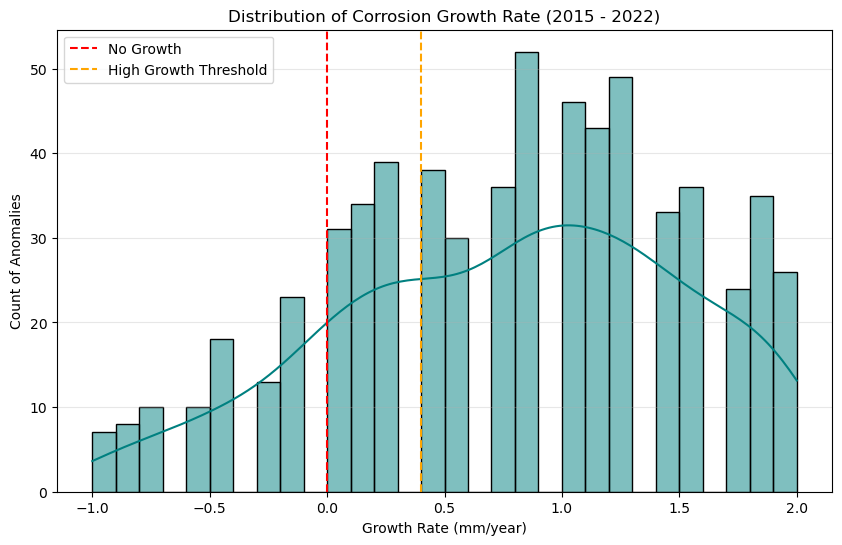

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_growth_distribution(df_growth):
    plt.figure(figsize=(10, 6))
    
    data_plot = df_growth[df_growth['depth_growth_per_year'].between(-1, 2)]
    
    sns.histplot(data_plot['depth_growth_per_year'], kde=True, color='teal', bins=30)
    plt.axvline(0, color='red', linestyle='--', label='No Growth')
    plt.axvline(0.4, color='orange', linestyle='--', label='High Growth Threshold')
    
    plt.title('Distribution of Corrosion Growth Rate (2015 - 2022)')
    plt.xlabel('Growth Rate (mm/year)')
    plt.ylabel('Count of Anomalies')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

plot_growth_distribution(df_growth_15_22)

In [47]:
df_22["feature_type"].unique()

array(['GIRTH_WELD', 'FITTING_TEE_TAP', 'VALVE', 'BEND', 'OTHER_FEATURE',
       'METAL_LOSS', 'SEAM_WELD_ANOMALY', 'AGM',
       'METAL_LOSS_MANUFACTURING', 'REPAIR_PROTECTION', 'DENT', 'CASING',
       'FLANGE'], dtype=object)

In [ ]:
REFERENCE_TYPES = [
    "GIRTH_WELD",
    "SEAM_WELD_ANOMALY",
    "VALVE",
    "FLANGE",
    "FITTING_TEE_TAP",
    "CASING"
]

df_ref = df[df["feature_type"].isin(REFERENCE_TYPES)]


In [53]:
!pip install -U libauc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [libauc]2m6/8 [ogb]h-geometric]


In [56]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler
from libauc.losses import AUCMLoss
from libauc.optimizers import PESG

# ==========================================
# 1. TIỀN XỬ LÝ & CHUẨN HÓA (Standardization)
# ==========================================
DEGRADATION_TYPES = ['METAL_LOSS', 'DENT', 'ANOMALY', 'LOSS_MANUFACTURING']

def preprocess_and_scale(df_list):
    """Tiền xử lý và chuẩn hóa chung cho tất cả các năm"""
    combined_features = []
    processed_dfs = []
    
    scaler = StandardScaler()
    
    # Bước 1: Trích xuất và mã hóa Clock
    for df in df_list:
        temp = df.copy()
        temp = temp[temp["feature_type"].isin(DEGRADATION_TYPES)]
        temp = temp.dropna(subset=["depth", "length", "width", "clock"])
        
        rad = temp["clock"] * 2 * math.pi / 12
        temp["clock_sin"] = np.sin(rad)
        temp["clock_cos"] = np.cos(rad)
        
        features = ["depth", "length", "width", "clock_sin", "clock_cos"]
        combined_features.append(temp[features].values)
        processed_dfs.append(temp)
    
    # Bước 2: Fit scaler trên toàn bộ dữ liệu lịch sử để đồng nhất thang đo
    all_data = np.vstack(combined_features)
    scaler.fit(all_data)
    
    tensors = [torch.tensor(scaler.transform(f), dtype=torch.float32) for f in combined_features]
    return tensors, processed_dfs

# Chạy tiền xử lý
(X_2022, X_2015, X_2007), (df_22_c, df_15_c, df_07_c) = preprocess_and_scale([df_22, df_15_aligned, df_07_aligned])

# ==========================================
# 2. KIẾN TRÚC MẠNG & SSL DATASET
# ==========================================
class SSLPairDataset(Dataset):
    def __init__(self, x):
        self.x = x
    def __len__(self): return len(self.x)
    def __getitem__(self, idx):
        anchor = self.x[idx]
        # Positive: Thêm nhiễu 10% để AI học tính bất biến
        positive = anchor + torch.randn_like(anchor) * 0.1
        # Negative: Lấy một mẫu ngẫu nhiên khác
        neg_idx = np.random.randint(0, len(self.x))
        negative = self.x[neg_idx]
        return anchor, positive, negative

class Encoder(nn.Module):
    def __init__(self, in_dim=5, emb_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, emb_dim)
        )
    def forward(self, x): return self.net(x)

# ==========================================
# 3. HUẤN LUYỆN (SELF-SUPERVISED)
# ==========================================
X_unlabeled = torch.cat([X_2007, X_2015], dim=0)
train_loader = DataLoader(SSLPairDataset(X_unlabeled), batch_size=64, shuffle=True)

encoder = Encoder()
loss_fn = AUCMLoss()
optimizer = PESG(encoder.parameters(), loss_fn=loss_fn, lr=1e-3, margin=1.0)



print(">>> Đang train AI bằng SSL (với Negative Sampling)...")
encoder.train()
for epoch in range(50):
    total_loss = 0
    for anchor, positive, negative in train_loader:
        z_a = F.normalize(encoder(anchor), dim=1)
        z_p = F.normalize(encoder(positive), dim=1)
        z_n = F.normalize(encoder(negative), dim=1)
        
        # Điểm tương đồng
        pos_scores = (z_a * z_p).sum(dim=1)
        neg_scores = (z_a * z_n).sum(dim=1)
        
        # Gộp nhãn: Positive=1, Negative=0
        scores = torch.cat([pos_scores, neg_scores])
        targets = torch.cat([torch.ones(len(pos_scores)), torch.zeros(len(neg_scores))])
        
        loss = loss_fn(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Avg Loss: {total_loss/len(train_loader):.4f}")

# ==========================================
# 4. KHỚP LỖI (2015 -> 2022) & XUẤT BÁO CÁO
# ==========================================
encoder.eval()
with torch.no_grad():
    z15 = F.normalize(encoder(X_2015), dim=1)
    z22 = F.normalize(encoder(X_2022), dim=1)
    sim_matrix = torch.matmul(z15, z22.T).cpu().numpy()

row_ind, col_ind = linear_sum_assignment(-sim_matrix)

THRESHOLD = 0.8  # Ngưỡng tin cậy AI
final_results = []
matched_22_indices = set()

for i15, i22 in zip(row_ind, col_ind):
    score = sim_matrix[i15, i22]
    r15, r22 = df_15_c.iloc[i15], df_22_c.iloc[i22]
    
    if score >= THRESHOLD:
        final_results.append({
            "rec_index": r22.name + 1, "hist_index": r15.name + 1,
            "match_type": "MATCHED", "distance": round(r22["distance"], 2),
            "depth_15": r15["depth"], "depth_22": r22["depth"],
            "growth": round(r22["depth"] - r15["depth"], 3),
            "ai_conf": round(score, 4)
        })
        matched_22_indices.add(i22)

# Thêm New Anomalies
for i22 in range(len(df_22_c)):
    if i22 not in matched_22_indices:
        r22 = df_22_c.iloc[i22]
        final_results.append({
            "rec_index": r22.name + 1, "hist_index": None,
            "match_type": "NEW", "distance": round(r22["distance"], 2),
            "depth_15": None, "depth_22": r22["depth"],
            "growth": None, "ai_conf": 0
        })

df_final = pd.DataFrame(final_results).sort_values("distance")
df_final.to_csv("ai_integrity_final_report.csv", index=False)
print("\n>>> Xong! File 'ai_integrity_final_report.csv' đã sẵn sàng.")

>>> Đang train AI bằng SSL (với Negative Sampling)...
Epoch 10 | Avg Loss: 0.1863
Epoch 20 | Avg Loss: 0.0547
Epoch 30 | Avg Loss: 0.0068
Epoch 40 | Avg Loss: -0.0053
Epoch 50 | Avg Loss: 0.0030

>>> Xong! File 'ai_integrity_final_report.csv' đã sẵn sàng.


In [58]:
# Tổng hợp thống kê
total_anomalies_2022 = len(df_final)
new_anomalies = len(df_final[df_final['match_type'] == 'NEW'])
matched_anomalies = len(df_final[df_final['match_type'] == 'MATCHED'])

percent_new = (new_anomalies / total_anomalies_2022) * 100

print(f"--- THỐNG KÊ KẾT QUẢ KHỚP LỖI (2015 - 2022) ---")
print(f"Tổng số lỗi ghi nhận năm 2022: {total_anomalies_2022}")
print(f"Số lỗi cũ đã tồn tại (MATCHED): {matched_anomalies}")
print(f"Số lỗi mới phát sinh (NEW):     {new_anomalies}")
print(f"Tỷ lệ lỗi mới xuất hiện:        {percent_new:.2f}%")

# Lưu thống kê vào file text để làm báo cáo
with open("thong_ke_ai.txt", "w", encoding="utf-8") as f:
    f.write(f"Tong so loi 2022: {total_anomalies_2022}\n")
    f.write(f"Loi cu (Matched): {matched_anomalies}\n")
    f.write(f"Loi moi (New): {new_anomalies}\n")
    f.write(f"Ty le loi moi: {percent_new:.2f}%\n")

--- THỐNG KÊ KẾT QUẢ KHỚP LỖI (2015 - 2022) ---
Tổng số lỗi ghi nhận năm 2022: 2624
Số lỗi cũ đã tồn tại (MATCHED): 1262
Số lỗi mới phát sinh (NEW):     1362
Tỷ lệ lỗi mới xuất hiện:        51.91%


In [57]:
# Giả sử dự báo cho 5 năm tiếp theo (đến năm 2027)
YEARS_BETWEEN_INSPECTION = 7
PREDICTION_WINDOW = 5 

def calculate_predictions(row):
    if row['match_type'] == 'MATCHED':
        # Tốc độ tăng trưởng hàng năm (mm hoặc % mỗi năm)
        annual_rate = row['growth'] / YEARS_BETWEEN_INSPECTION
        # Dự báo độ sâu sau 5 năm nữa
        predicted_depth_2027 = row['depth_22'] + (annual_rate * PREDICTION_WINDOW)
        return annual_rate, predicted_depth_2027
    else:
        # Đối với lỗi NEW, vì không có mốc 2015, ta coi như nó mọc từ 0% trong 7 năm
        annual_rate = row['depth_22'] / YEARS_BETWEEN_INSPECTION
        predicted_depth_2027 = row['depth_22'] + (annual_rate * PREDICTION_WINDOW)
        return annual_rate, predicted_depth_2027

# Áp dụng tính toán
df_final[['annual_growth_rate', 'predicted_depth_2027']] = df_final.apply(
    lambda x: pd.Series(calculate_predictions(x)), axis=1
)

# Làm tròn kết quả
df_final['annual_growth_rate'] = df_final['annual_growth_rate'].round(4)
df_final['predicted_depth_2027'] = df_final['predicted_depth_2027'].round(2)

# Xuất bản báo cáo có dự báo
df_final.to_csv("ai_integrity_prediction_report.csv", index=False)
print("\n>>> Đã xuất bản báo cáo DỰ BÁO: 'ai_integrity_prediction_report.csv'")


>>> Đã xuất bản báo cáo DỰ BÁO: 'ai_integrity_prediction_report.csv'
